In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-06-11 08:16:47--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.118
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  15.9MB/s    in 1.6s    

2019-06-11 08:16:49 (15.9 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-06-11 08:16:51--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.74
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [0]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
# For CGAN
mnist= input_data.read_data_sets("MNIST_Fashion/",one_hot= True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

(55000, 784)
(10000, 784)
(55000, 10)
(10000, 10)


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02352941 0.         0.         0.35686275 0.39607847 0.4156863
 0.4156863  0.1764706  0.         0.         0.00392157 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02745098 0.         0.06666667
 0.6431373  0.22352943 0.07843138 0.08235

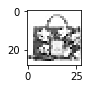

In [6]:
plt.figure(figsize=(1,1))
sample_image = mnist.train.next_batch(1)[0]
print(sample_image[0])

sample_image = sample_image.reshape([28,28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
#Training Parameters 

learning_rate=0.0002
batch_size=128
epochs=100000

#Network Parameters

image_dim=784       # Image size is 28x28
Y_dimension=10      # For CGAN
gen_hidd_dim=256
disc_hidd_dim=256
z_noise_dim=100     # Input noise datapoint

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [8]:
# for  CGAN
weights= {"disc_H" : tf.Variable(xavier_init([image_dim + Y_dimension, disc_hidd_dim])),
          "disc_final" : tf.Variable(xavier_init([disc_hidd_dim, 1])),
          "gen_H" : tf.Variable(xavier_init([z_noise_dim + Y_dimension, gen_hidd_dim])),
          "gen_final" : tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
         }

bias= {"disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
       "disc_final" : tf.Variable(xavier_init([1])),
       "gen_H" : tf.Variable(xavier_init([gen_hidd_dim])),
       "gen_final" : tf.Variable(xavier_init([image_dim]))
      }

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Creating the computational graph
#Define Discriminator function


# for CGAN
def Discriminator(x,y):
  inputs = tf.concat(axis = 1, values=[x,y])
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(inputs, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output



# for CGAN
# Define generator network 
def Generator(x,y):
  inputs = tf.concat(axis = 1, values=[x,y])
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(inputs, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"])
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output



# for CGAN
# Define the placeholders for External Input
x_input= tf.placeholder(tf.float32, shape = [None, image_dim], name="real_input")
Y_input= tf.placeholder(tf.float32, shape = [None, Y_dimension], name="Labels")
z_input= tf.placeholder(tf.float32, shape = [None, z_noise_dim], name="input_noise")

 
# for CGAN
# Building the Generator Network
output_Gen = Generator(z_input, Y_input)
 

# for CGAN
# Buidling the Discriminator Network 
real_output1_Disc, real_output_Disc = Discriminator(x_input, Y_input) # Implements D(x)
fake_output1_Disc, fake_output_Disc = Discriminator(output_Gen, Y_input) # Implements D(G(x))

In [0]:
#First kind of loss
#with tf.name_scope("Discriminator_Loss") as scope:
 # Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc+0.0001) + tf.log(1.- fake_output_Disc+0.0001))
  
#with tf.name_scope("Generator_Loss") as scope:
 # Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc+0.0001)) # due to max log(D(G(x)))
  
# Tensorboard Summary
#Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
#Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_Loss)

In [0]:
# Second kind of loss
Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels= tf.ones_like(real_output1_Disc)))
Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels= tf.zeros_like(fake_output1_Disc)))
Discriminator_Loss = Disc_real_loss + Disc_fake_loss

Generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels= tf.ones_like(fake_output1_Disc)))

#Tensorboard Summary
Disc_loss_real_summary = tf.summary.scalar("Disc_loss_real", Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar("Disc_loss_fake", Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar("Disc_Total_Loss", Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary])
Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_loss)


In [0]:
# Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

In [0]:
#Define the optimizer 

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(Discriminator_Loss, var_list= Discriminator_var)
  
with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Generator_loss, var_list= Generator_var)

In [17]:
# Initialize the variables
init = tf.global_variables_initializer()

sess=tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):

  #for CGAN
  X_batch, Y_label = mnist.train.next_batch(batch_size)
  
  
  #for CGAN
  # Generate noise to feed the discriminator
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch= sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:X_batch,Y_input: Y_label, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_loss], feed_dict = {z_input:z_noise, Y_input: Y_label})
  
  
  #for CGAN
  # Running the Discriminator summary
  summary_Disc_Loss = sess.run(Disc_loss_total, feed_dict={x_input:X_batch, z_input:z_noise, Y_input: Y_label})
  
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_Loss, epoch)
  
  
  # for CGAN
  # Running the Generator summary
  summary_Gen_Loss = sess.run(Gen_loss_total, feed_dict={z_input:z_noise, Y_input: Y_label})
  
  #Adding the Generator summary
  writer.add_summary(summary_Gen_Loss, epoch)
  
  if epoch % 2000 ==0:
    print("Steps: {0} : Generator Loss: {1}, Discriminator Loss: {2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  

Steps: 0 : Generator Loss: 1.4675860404968262, Discriminator Loss: 1.7403345108032227
Steps: 2000 : Generator Loss: 4.749839782714844, Discriminator Loss: 0.04120923578739166
Steps: 4000 : Generator Loss: 4.0814313888549805, Discriminator Loss: 0.11454446613788605
Steps: 6000 : Generator Loss: 3.4098076820373535, Discriminator Loss: 0.25700417160987854
Steps: 8000 : Generator Loss: 3.7110233306884766, Discriminator Loss: 0.25778454542160034
Steps: 10000 : Generator Loss: 3.5367658138275146, Discriminator Loss: 0.3248119652271271
Steps: 12000 : Generator Loss: 3.6207449436187744, Discriminator Loss: 0.3961750864982605
Steps: 14000 : Generator Loss: 3.5167086124420166, Discriminator Loss: 0.3987720012664795
Steps: 16000 : Generator Loss: 3.6231069564819336, Discriminator Loss: 0.3809390664100647
Steps: 18000 : Generator Loss: 3.470442771911621, Discriminator Loss: 0.5928710103034973
Steps: 20000 : Generator Loss: 3.820683479309082, Discriminator Loss: 0.508980929851532
Steps: 22000 : Gen

In [0]:
from matplotlib import gridspec
# for CGAN
def generate_plot(samples):
  fig = plt.figure(figsize =(4,4))
  gs= gridspec.GridSpec(4,4)
  gs.update(wspace = 0.05, hspace= 0.05)
  
  for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='gray')
  return fig

In [0]:
def create(inp):
  feature_map={ "T-shirt" : 0,
                "Trouser" : 1,
               "Pullover" : 2,
               "Dress" : 3,
               "Coat" : 4,
               "Sandal" : 5,
                "Shirt" : 6,
               "Sneaker" : 7,
               "Bag" : 8,
               "Ankle boot" : 9,
              }
  
  # Number of samples to be displayed for each category
  samples=16
  
  z_noise = np.random.uniform(-1.,1., size= [samples, z_noise_dim])
  
  # Create one-hot label vector
  Y_label = np.zeros(shape = [samples, Y_dimension])
  Y_label[:, feature_map[inp]] = 1
  
  # Run the trained generator excluding discriminator
  generated_samples = sess.run(output_Gen, feed_dict={z_input:z_noise, Y_input:Y_label})
  
  # plotting the image
  generate_plot(generated_samples)

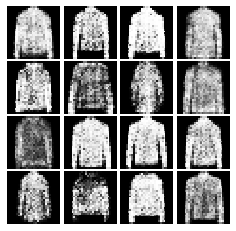

In [20]:
create("Coat")